# Simulated Quad Scan

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pyemittance.emittance_calc import EmitCalc

In [9]:
from pyemittance.load_json_configs import load_configs
from pyemittance.optics import drift_mat2

CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']['rMatx'] = drift_mat2(2.2)
CONFIG['beamline_info']['rMaty'] = drift_mat2(2.2)
CONFIG['beamline_info']['Lquad'] = 0.108
CONFIG['beamline_info']

{'name': 'LCLS2',
 'species': 'electron',
 'Lquad': 0.108,
 'energy': 80000000.0,
 'Twiss0': [1e-06, 1e-06, 5.01, 5.01, 0.049, 0.049],
 'rMatx': array([[1. , 2.2],
        [0. , 1. ]]),
 'rMaty': array([[1. , 2.2],
        [0. , 1. ]])}

In [10]:
CONFIG['meas_pv_info']

{'diagnostic': {'pv': {'name': 'OTRS:HTR:330',
   'image': 'OTRS:HTR:330:Image:ArrayData',
   'ncol': 'OTRS:HTR:330:Image:ArraySize1_RBV',
   'nrow': 'OTRS:HTR:330:Image:ArraySize0_RBV',
   'resolution': 'OTRS:HTR:330:RESOLUTION',
   'profmonxsize': 'OTRS:HTR:330:XRMS',
   'profmonysize': 'OTRS:HTR:330:YRMS',
   'scan': '',
   'xsize': '',
   'ysize': ''},
  'pv_unit': {'resolution': '(um)'}},
 'meas_device': {'pv': {'name': 'QUAD:HTR:120',
   'cntrl': 'QUAD:HTR:120:BCTRL',
   'read': 'QUAD:HTR:120:BACT'},
  'pv_unit': 'kG'},
 'beam_info': {'energy': ''}}

# Simulation

In [20]:
import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6

from pyemittance.optics import quad_mat2, propagate_sigma, sigma_from_twiss
from pyemittance.optics import machine_value_from_kL, kL_from_machine_value

BUNCH_PARAMS0 = {
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}

class BeamSim:
    def __init__(self, bunch_parms=BUNCH_PARAMS0, beamline_info=None) -> None:
        self.bunch_parms = bunch_parms.copy()
        self.beamline_info = beamline_info.copy()
        self.configure()
        
    def configure(self):
        self.energy = self.beamline_info['energy']
        self.rmatx = np.array(self.beamline_info['rMatx']).reshape(2,2)
        self.rmaty = np.array(self.beamline_info['rMaty']).reshape(2,2)
        self.Lquad = self.beamline_info['Lquad']

    def initial_sigma_matrix2(self, dim=''):
        norm_emit = self.bunch_parms[f'norm_emit_{dim}']
        gammabeta = np.sqrt((self.bunch_parms['energy']/mec2)**2 -1)
        emit = norm_emit / gammabeta
        beta = self.bunch_parms[f'beta_{dim}']
        alpha = self.bunch_parms[f'alpha_{dim}']
        return sigma_from_twiss(emit, beta, alpha)
    
    def beam_size_meas(self, quad_value):
        kL = kL_from_machine_value(quad_value, self.energy)
        # X
        sigma0 = self.initial_sigma_matrix2('x')
        mat2 = self.rmatx @ quad_mat2(kL, L=self.Lquad)
        sigma1 = propagate_sigma(sigma0, mat2)
        meas_sigma_x =  np.sqrt(sigma1[0,0])
        # Y
        sigma0 =  self.initial_sigma_matrix2('y')
        mat2 = self.rmaty @ quad_mat2(-kL, L=self.Lquad)
        sigma1 = propagate_sigma(sigma0, mat2) 
        meas_sigma_y =  np.sqrt(sigma1[0,0])
        return meas_sigma_x, meas_sigma_y
        
         


sim = BeamSim(beamline_info=CONFIG['beamline_info'])

sim.beam_size_meas(quad_value=0.0)

(0.0003164910841730345, 0.0005379602586827037)

# Measurements

# Make the data

In [21]:
quad_vals = np.linspace(-2,2, 20)
meas =  np.array([sim.beam_size_meas(v) for v in quad_vals])
meas_x = meas[:,0]
meas_y = meas[:,1]

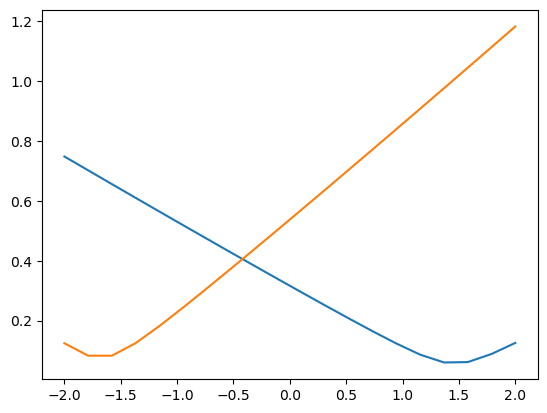

In [22]:
plt.plot(quad_vals, meas_x*1e3)
plt.plot(quad_vals, meas_y*1e3)

# Emittance calculation

(1.0000000000000012e-06,
 1.9999999999999957e-06,
 9.999999999999993,
 11.000000000000021,
 -0.9999999999999987,
 -2.000000000000005)

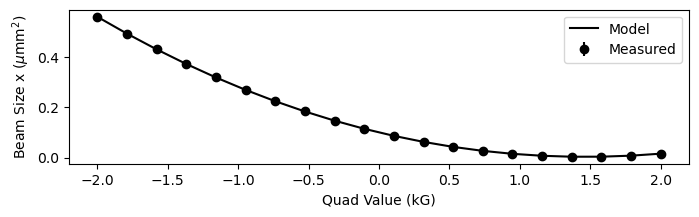

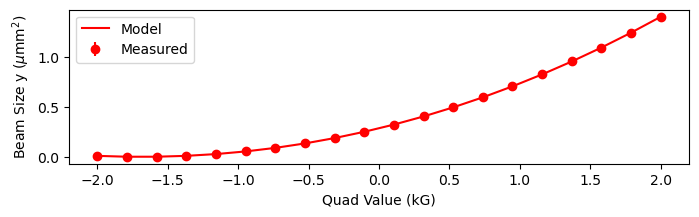

In [23]:
ef = EmitCalc({'x': quad_vals,'y': quad_vals},
              {'x': meas_x ,'y': meas_y},
              {'x': meas_x*0.03 ,'y': meas_y*0.03},
              config_dict=CONFIG,
             )

ef.plot = True             
result = ef.get_emit()

result['norm_emit_x'], result['norm_emit_y'], result['beta_x'], result['beta_y'], result['alpha_x'], result['alpha_y']

In [24]:
print(ef.summary())

"
    Emittance Calculation Summary
    
    Emittance x: 1.000 +/- 0.022 mm mrad
    Emittance y: 2.000 +/- 0.046 mm mrad
    
    Before scanning quad:
                    x        y
    norm_emit      1.00      2.00 (mm-mrad)                    
    beta          10.00     11.00 (m)
    alpha         -1.00     -2.00 (1)

    
    
